MODEL TRAINING


In [1]:
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pickle import load
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.layers import GRU, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, ELU, ReLU
from tensorflow.keras import Sequential, regularizers
from tensorflow.python.client import device_lib


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
X_train = np.load(f"/content/drive/MyDrive/FINAL_PROJECT/PROJECT/AMAZON/X_train.npy", allow_pickle=True)
y_train = np.load("/content/drive/MyDrive/FINAL_PROJECT/PROJECT/AMAZON/y_train.npy", allow_pickle=True)
X_test = np.load("/content/drive/MyDrive/FINAL_PROJECT/PROJECT/AMAZON/X_test.npy", allow_pickle=True)
y_test = np.load("/content/drive/MyDrive/FINAL_PROJECT/PROJECT/AMAZON/y_test.npy", allow_pickle=True)
yc_train = np.load("/content/drive/MyDrive/FINAL_PROJECT/PROJECT/AMAZON/yc_train.npy", allow_pickle=True)
yc_test = np.load("/content/drive/MyDrive/FINAL_PROJECT/PROJECT/AMAZON/yc_test.npy", allow_pickle=True)


epoch 15 d_loss 3.74969 g_loss 0.426366


epoch 30 d_loss 1.0027732 g_loss 0.46092853


epoch 45 d_loss 0.27626893 g_loss 0.6855677


epoch 60 d_loss 0.24781823 g_loss 0.6867938


epoch 75 d_loss 0.12583658 g_loss 0.7964516


epoch 90 d_loss 0.09080966 g_loss 0.88085717


epoch 105 d_loss 0.05884411 g_loss 0.94115657


epoch 120 d_loss 0.047326557 g_loss 0.95700186


epoch 135 d_loss 0.03942971 g_loss 0.97435606


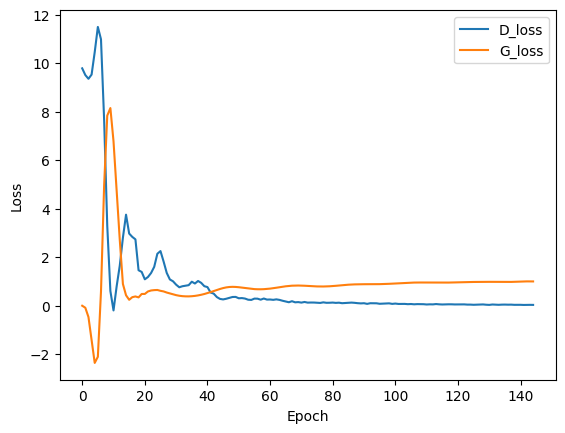

REAL (160, 1)
[[ 0.53534245]
 [ 0.62171342]
 [ 0.73445048]
 [ 0.78535147]
 [ 0.7489729 ]
 [ 0.85473916]
 [ 0.7405719 ]
 [ 0.72899533]
 [ 0.7928191 ]
 [ 0.8177058 ]
 [ 0.8116691 ]
 [ 0.8217304 ]
 [ 1.        ]
 [ 0.97637406]
 [ 0.85030245]
 [ 0.85935788]
 [ 0.85980625]
 [ 0.76785915]
 [ 0.83696829]
 [ 0.77090192]
 [ 0.69410763]
 [ 0.68639768]
 [ 0.62873232]
 [ 0.67428765]
 [ 0.79056431]
 [ 0.79040672]
 [ 0.74223294]
 [ 0.69473801]
 [ 0.63062346]
 [ 0.61908313]
 [ 0.7214796 ]
 [ 0.61373711]
 [ 0.6415334 ]
 [ 0.57029082]
 [ 0.65121921]
 [ 0.66625067]
 [ 0.66701423]
 [ 0.63309615]
 [ 0.65713457]
 [ 0.62173783]
 [ 0.6082457 ]
 [ 0.56151433]
 [ 0.65091585]
 [ 0.58103133]
 [ 0.50429733]
 [ 0.47755575]
 [ 0.46058468]
 [ 0.43469137]
 [ 0.52866316]
 [ 0.52490529]
 [ 0.42809716]
 [ 0.45049897]
 [ 0.3724195 ]
 [ 0.30893533]
 [ 0.196647  ]
 [-0.0221471 ]
 [ 0.02394169]
 [-0.086565  ]
 [-0.11356111]
 [-0.0950141 ]
 [ 0.01021908]
 [ 0.14587919]
 [ 0.18515514]
 [ 0.17106925]
 [-0.11421554]
 [ 0.341435

<Figure size 640x480 with 0 Axes>

In [4]:



# Define the generator
def Generator(input_dim, output_dim, feature_size) -> tf.keras.models.Model:
    model = Sequential()
    model.add(GRU(units=256,
                  return_sequences=True,
                  input_shape=(input_dim, feature_size),
                  recurrent_dropout=0.02,
                  recurrent_regularizer=regularizers.l2(1e-3)))
    model.add(GRU(units=128,
                  #return_sequences=True,
                  recurrent_dropout=0.02,
                  recurrent_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(128, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(64, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(16, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(8, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(units=output_dim))
    return model

# Define the discriminator
def Discriminator() -> tf.keras.models.Model:
    model = tf.keras.Sequential()
    model.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(64, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(128, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Flatten())
    model.add(Dense(220, use_bias=True))
    model.add(LeakyReLU())
    model.add(Dense(220, use_bias=True))
    model.add(ReLU())
    model.add(Dense(1))
    return model

# Train WGAN-GP model
class GAN():
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.d_optimizer = tf.keras.optimizers.Adam(0.001)
        self.g_optimizer = tf.keras.optimizers.Adam(0.001)
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = 128
        checkpoint_dir = '../training_checkpoints'
        self.checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.g_optimizer,
                                              discriminator_optimizer=self.d_optimizer,
                                              generator=self.generator,
                                              discriminator=self.discriminator)

    def gradient_penalty(self, batch_size, real_output, fake_output):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # get the interpolated data
        alpha = tf.random.normal([batch_size, 4, 1], 0.0, 1.0)
        diff = fake_output - tf.cast(real_output, tf.float32)
        interpolated = tf.cast(real_output, tf.float32) + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]

        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))

        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_input, real_price, yc = data
        batch_size = tf.shape(real_input)[0]
        for _ in range(1):
            with tf.GradientTape() as d_tape:
                # Train the discriminator
                # generate fake output
                generated_data = self.generator(real_input, training=True)
                # reshape the data
                generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
                fake_output = tf.concat([generated_data_reshape, tf.cast(yc, tf.float32)], axis=1)
                real_y_reshape = tf.reshape(real_price, [real_price.shape[0], real_price.shape[1], 1])
                real_output = tf.concat([tf.cast(real_y_reshape, tf.float32), tf.cast(yc, tf.float32)], axis=1)
                # Get the logits for the fake images
                D_real = self.discriminator(real_output, training=True)
                # Get the logits for real images
                D_fake = self.discriminator(fake_output, training=True)
                # Calculate discriminator loss using fake and real logits
                real_loss = tf.cast(tf.reduce_mean(D_real), tf.float32)
                fake_loss = tf.cast(tf.reduce_mean(D_fake), tf.float32)
                d_cost = fake_loss-real_loss
                # Calculate the gradientjiu penalty
                gp = self.gradient_penalty(batch_size, real_output, fake_output)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * 10

            d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        for _ in range(3):
            with tf.GradientTape() as g_tape:
                # Train the generator
                # generate fake output
                generated_data = self.generator(real_input, training=True)
                # reshape the data
                generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
                fake_output = tf.concat([generated_data_reshape, tf.cast(yc, tf.float32)], axis=1)
                # Get the discriminator logits for fake images
                G_fake = self.discriminator(fake_output, training=True)
                # Calculate the generator loss
                g_loss = -tf.reduce_mean(G_fake)
            g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return real_price, generated_data, {'d_loss': d_loss, 'g_loss': g_loss}

    def train(self, X_train, y_train, yc, epochs):
        data = X_train, y_train, yc
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []


        for epoch in range(epochs):
            start = time.time()

            real_price, fake_price, loss = self.train_step(data)

            G_losses = []
            D_losses = []

            Real_price = []
            Predicted_price = []

            D_losses.append(loss['d_loss'].numpy())
            G_losses.append(loss['g_loss'].numpy())

            Predicted_price.append(fake_price)
            Real_price.append(real_price)

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                tf.keras.models.save_model(generator, 'gen_GRU_model_%d.h5' % epoch)
                self.checkpoint.save(file_prefix=self.checkpoint_prefix)
                print('epoch', epoch+1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy())

            # For printing loss
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_losses'].append(D_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)

        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        # Plot the loss
        plt.plot(train_hist['D_losses'], label='D_loss')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.savefig('train_loss.png')

        print("REAL", Real_price.shape)
        print(Real_price)
        print("PREDICTED", Predicted_price.shape)
        print(Predicted_price)

        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

if __name__ == '__main__':
    input_dim = X_train.shape[1]
    feature_size = X_train.shape[2]
    output_dim = y_train.shape[1]
    epoch = 145

    generator = Generator(X_train.shape[1], output_dim, X_train.shape[2])
    discriminator = Discriminator()
    gan = GAN(generator, discriminator)
    Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, epoch)




In [6]:
generator.save('/content/drive/MyDrive/FINAL_PROJECT/PROJECT/AMAZON/generator_model.h5')
discriminator.save('/content/drive/MyDrive/FINAL_PROJECT/PROJECT/AMAZON/discriminator_model.h5')


In [8]:
# Rescale back the real dataset
y_scaler = load(open('/content/drive/MyDrive/FINAL_PROJECT/PROJECT/AMAZON/y_scaler.pkl', 'rb'))
X_scaler = load(open('/content/drive/MyDrive/FINAL_PROJECT/PROJECT/AMAZON/X_scaler.pkl', 'rb'))
train_predict_index = np.load("/content/drive/MyDrive/FINAL_PROJECT/PROJECT/AMAZON/index_train.npy", allow_pickle=True)
test_predict_index = np.load("/content/drive/MyDrive/FINAL_PROJECT/PROJECT/AMAZON/index_test.npy", allow_pickle=True)


----- predicted price ----- [[ 0.44077402]
 [ 0.4175163 ]
 [ 0.44450727]
 [ 0.4889904 ]
 [ 0.556139  ]
 [ 0.59815663]
 [ 0.6436359 ]
 [ 0.643552  ]
 [ 0.65064865]
 [ 0.6384352 ]
 [ 0.6635064 ]
 [ 0.67960685]
 [ 0.6860024 ]
 [ 0.717299  ]
 [ 0.75365275]
 [ 0.7620271 ]
 [ 0.7371488 ]
 [ 0.7130229 ]
 [ 0.6954275 ]
 [ 0.68392587]
 [ 0.66956204]
 [ 0.64282995]
 [ 0.61370444]
 [ 0.5611333 ]
 [ 0.54842156]
 [ 0.5664227 ]
 [ 0.5981429 ]
 [ 0.61330014]
 [ 0.60148066]
 [ 0.5746198 ]
 [ 0.54538864]
 [ 0.53183126]
 [ 0.528251  ]
 [ 0.5582646 ]
 [ 0.52828324]
 [ 0.5297757 ]
 [ 0.548893  ]
 [ 0.56820786]
 [ 0.5839069 ]
 [ 0.57705146]
 [ 0.570744  ]
 [ 0.5672813 ]
 [ 0.54179484]
 [ 0.5175402 ]
 [ 0.5183298 ]
 [ 0.49313998]
 [ 0.44721034]
 [ 0.41509804]
 [ 0.3857145 ]
 [ 0.3655855 ]
 [ 0.3812701 ]
 [ 0.40018976]
 [ 0.36960918]
 [ 0.32309818]
 [ 0.29500443]
 [ 0.24698068]
 [ 0.16493067]
 [ 0.06191936]
 [-0.02449465]
 [-0.05018954]
 [-0.06091568]
 [-0.05138974]
 [ 0.00521873]
 [ 0.08195599]
 [ 0.1516660

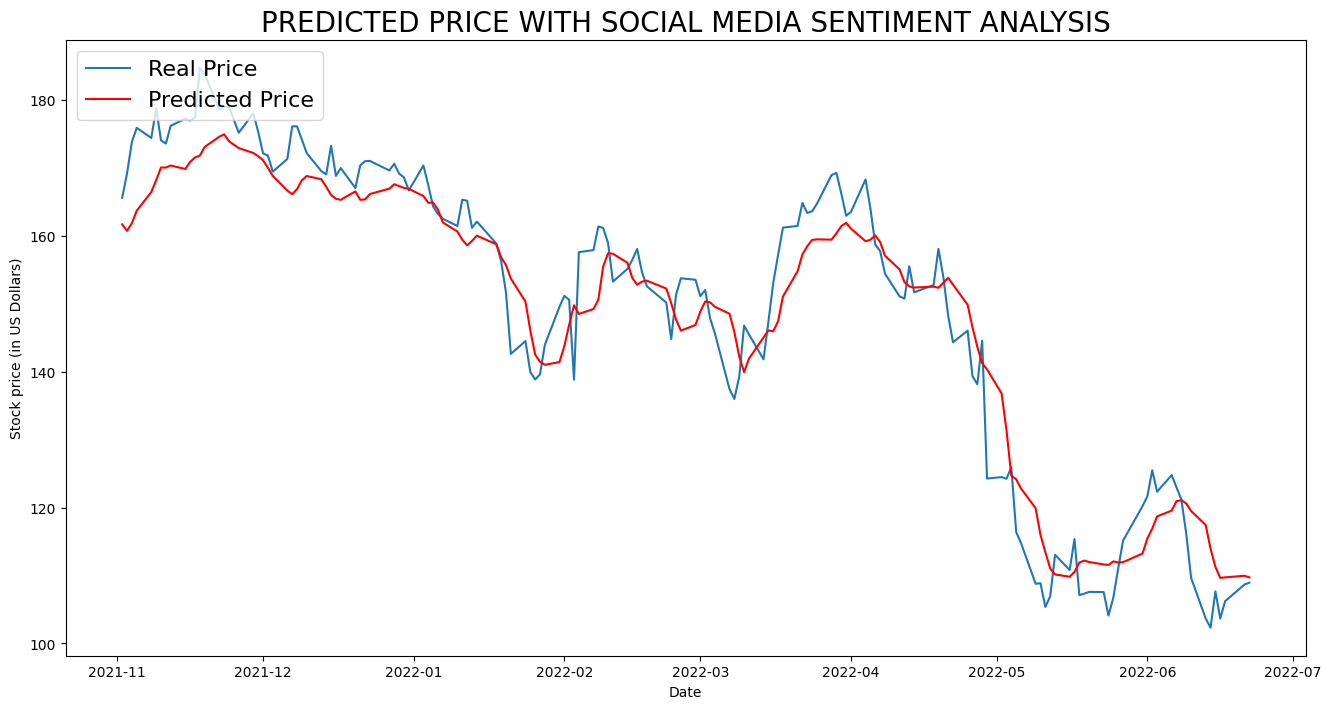

-- RMSE --  6.029556466592275


In [9]:
print("----- predicted price -----", Predicted_price)

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

print("----- rescaled predicted price -----", rescaled_Predicted_price)
print("----- SHAPE rescaled predicted price -----", rescaled_Predicted_price.shape)

predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)

# Plot the predicted result
plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"])
plt.plot(predict_result["predicted_mean"], color = 'r')
plt.xlabel("Date")
plt.ylabel("Stock price (in US Dollars)")
plt.legend(("Real Price", "Predicted Price"), loc="upper left", fontsize=16)
plt.title("PREDICTED PRICE WITH SOCIAL MEDIA SENTIMENT ANALYSIS", fontsize=20)
plt.savefig('/content/drive/MyDrive/FINAL_PROJECT/PROJECT/AMAZON/train_plot.png')
plt.show()

# Calculate RMSE
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('-- RMSE -- ', RMSE)

In [10]:
print(predicted,real)

2021-11-02    161.736877
2021-11-03    160.777588
2021-11-04    161.890854
2021-11-05    163.725632
2021-11-08    166.495285
                 ...    
2022-06-15    111.276680
2022-06-16    109.646584
2022-06-17    109.726349
2022-06-21    109.961815
2022-06-22    109.725410
Name: predicted_mean, Length: 160, dtype: float32 2021-11-02    165.637497
2021-11-03    169.199997
2021-11-04    173.850006
2021-11-05    175.949493
2021-11-08    174.449005
                 ...    
2022-06-15    107.669998
2022-06-16    103.660004
2022-06-17    106.220001
2022-06-21    108.680000
2022-06-22    108.949997
Name: real_mean, Length: 160, dtype: float64


In [11]:
# Calculate price changes
price_changes = np.diff(predicted)

# Define threshold
threshold = 0.0

# Predict future movements
future_predictions = []
for change in price_changes:
    if change > threshold:
        future_predictions.append("Up")
    else:
        future_predictions.append("Down")

# Get the prediction for the future date
future_prediction = future_predictions[-1]

# Print the prediction
print("Prediction for future date: ", future_prediction)

current_price =  130
# Compare with current price to determine movement
if current_price < predicted[-1]:
    actual_movement = "Up"
else:
    actual_movement = "Down"

# Print the actual movement based on current price
print("Actual movement based on current price: ", actual_movement)


Prediction for future date:  Down
Actual movement based on current price:  Down
